### Загрузка библиотек

In [1]:
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols

### Загрузка и подготовка данных

In [2]:
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/carData/Salaries.csv")
df.rename(columns = {"yrs.since.phd" : "phd", "yrs.service" : "service"},  inplace = True)

### Множественная регрессия

In [3]:
model = ols("salary ~ service + sex", df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     26.82
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           1.20e-11
Time:                        20:08:35   Log-Likelihood:                -4633.9
No. Observations:                 397   AIC:                             9274.
Df Residuals:                     394   BIC:                             9286.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    9.236e+04   4740.188     19.484      

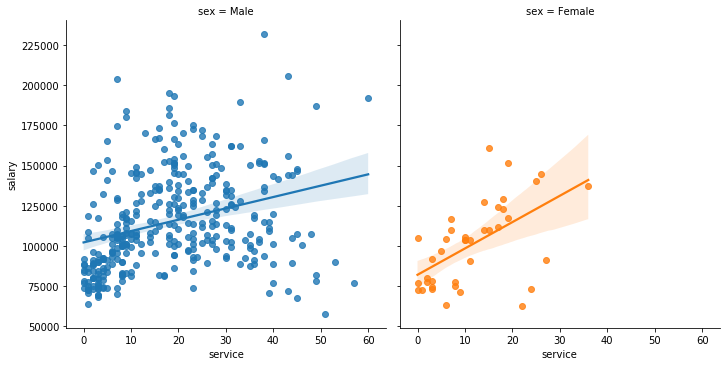

In [4]:
# различается ли эффект стажа на заработную плату у мужчин и женщин
# визуально, да, у женщин средняя з/п ниже, но взаимосвязь со стажем более сильная

sns.lmplot(data = df, x = "service", y = "salary", hue = "sex", col = "sex");

### Линейная модель с эффектом взаимодействия

In [5]:
model2 = ols("salary ~ service + sex + service:sex", df).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     18.98
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           1.62e-11
Time:                        20:08:36   Log-Likelihood:                -4632.4
No. Observations:                 397   AIC:                             9273.
Df Residuals:                     393   BIC:                             9289.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            8.207e+04   7

In [6]:
# salary = 82070 + 20130 * Male + 1637 * service - 931 * service * Male

# marginal effect of service: 1637 - 931 * Male
# for Female (Male = 0) marginal effect of service is 1637
# for Male (Male = 1) marginal effect of service is 1637 - 931 = 706

# marginal effect of Male: 20130 - 931 * service
# for person with average value of service marginal effect of Male is 20130 - 931 * 17.61 = 3735.09

In [7]:
df["service"].mean()

17.614609571788414

In [8]:
20130 - 931 * 17.61

3735.09

Итого: 

* при прочих равных условиях, если мы будем рассматривать только сотрудников женского пола, каждый дополнительный год опыта работы будет сопровождаться увеличением годовой заработной платы, в среднем, на 1637 долларов;

* при прочих равных условиях, если мы будем рассматривать только сотрудников мужского пола, каждый дополнительный год опыта работы будет сопровождаться увеличением годовой заработной платы, в среднем, на 706 долларов;

* при прочих равных условиях, если мы будем рассматривать сотрудников с одинаковым числом лет опыта работы, равным среднему по выборке (примерно 18 лет), у сотрудников мужского пола заработная плата, в среднем, будет на 3735.09 выше, чем у сотрудников женского пола;

In [9]:
# the same, but with * instead of :

model3 = ols("salary ~ sex * service", df).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     18.98
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           1.62e-11
Time:                        20:17:53   Log-Likelihood:                -4632.4
No. Observations:                 397   AIC:                             9273.
Df Residuals:                     393   BIC:                             9289.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            8.207e+04   7

### Влиятельные наблюдения

In [10]:
import numpy as np
from statsmodels.stats import outliers_influence 

In [11]:
# out stores different measures of influence

out = outliers_influence.OLSInfluence(model3)

In [12]:
# dfbetas: normalised differences in coefficients with i-th observation and without

dfbetas = out.dfbetas
abs_dfbetas = np.abs(dfbetas)
dfbetas_df = pd.DataFrame(abs_dfbetas)

# threshold for dfbetas is 2 / sqrt(n)
a = 2 / np.sqrt(len(dfbetas_df))

In [13]:
dfbetas_df["influence"] = (dfbetas_df[[0, 1, 2, 3]] > a).any(axis=1)
np.where(dfbetas_df["influence"])  # indices of potentially influencial points

(array([ 24,  47,  48,  52, 114, 119, 123, 133, 148, 230, 231, 237, 254,
        316, 323]),)

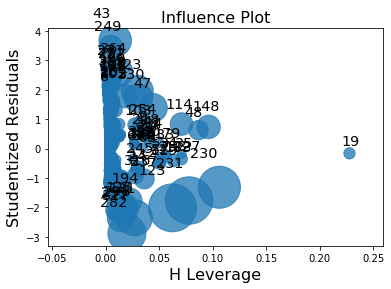

In [14]:
from statsmodels.api import graphics
graphics.influence_plot(model2);

In [ ]:
# influential points: high leverage and non-typical values (far from 0)
# points that lie in the right-upper and right-lower corner
# no such points